# Human face center point prediction
Using Biwi Kinect Head Pose dataset and ResNet18 transfer learning

In [41]:
from fastai.vision.all import *
dataset = untar_data(URLs.BIWI_HEAD_POSE)

In [2]:
dataset.ls()

(#50) [Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01.obj'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/02'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/02.obj'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/03'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/03.obj'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/04'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/04.obj'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/05'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/05.obj')...]

In [5]:
(dataset/'01').ls()

(#1000) [Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01/depth.cal'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01/frame_00003_rgb.jpg'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01/frame_00004_pose.txt'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01/frame_00004_rgb.jpg'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01/frame_00005_pose.txt'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01/frame_00005_rgb.jpg'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01/frame_00006_pose.txt'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01/frame_00006_rgb.jpg'),Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01/frame_00007_pose.txt')...]

Access .txt files containing Y data

In [9]:
img_files = get_image_files(dataset)
get_txt_for_img = lambda x: Path(f'{str(x)[:-7]}pose.txt')
get_txt_for_img(img_files[0])

Path('C:/Users/wysoc/.fastai/data/biwi_head_pose/01/frame_00003_pose.txt')

(480, 640)


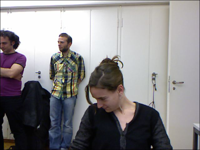

In [22]:
img = PILImage.create(img_files[900])
print(img.shape)
img.to_thumb(200)

## We need to access center points' coordinates

In [28]:
import numpy as np

cal = np.genfromtxt(dataset/'01'/'rgb.cal', skip_footer=6)
def get_center_point(image_path):
    ctr = np.genfromtxt(get_txt_for_img(image_path), skip_header=3)
    x_coord = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    y_coord = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([x_coord, y_coord])
    
get_center_point(img_files[0])

tensor([350.4915, 262.9643])

## Define dataset as an fastai Datablock

In [43]:
biwi_dataset = DataBlock(
    blocks=(ImageBlock, PointBlock), # notice there's a separate block for Point data
    get_items=get_image_files, # get X
    get_y=get_center_point, # get labels

    # we can't divide data into test and train randomly,
    # so we split it on one of the people
    splitter=FuncSplitter(lambda example: example.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240, 320)), # reduce size to speed up training
                Normalize.from_stats(*imagenet_stats)]
)

Let's see if it works correctly

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


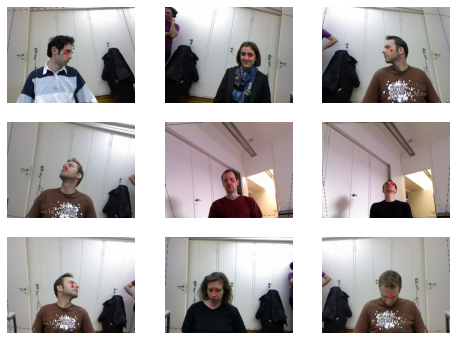

In [52]:
dls = biwi_dataset.dataloaders(source=dataset)
dls.show_batch(max_n=9, figsize=(8, 6))

Let's see the tensor shapes

In [53]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [54]:
y[0]

TensorPoint([[-0.0593,  0.1059]], device='cuda:0')

## Let's train a ResNet18

In [57]:
# coordinates in fastai and PyTorch are between -1 and 1
learner = vision_learner(dls, resnet18, y_range=(-1, 1))

# what loss function has been automatically assigned?
dls.loss_func

FlattenedLoss of MSELoss()

Find the learning rate

SuggestedLRs(valley=0.001737800776027143)

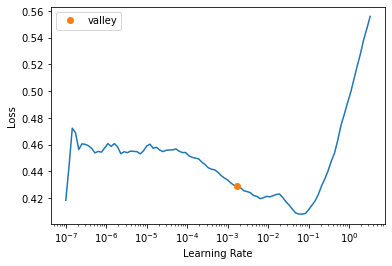

In [59]:
learner.lr_find()

In [60]:
# the suggestion is not too helpful because the high gradient area is small, so let's just pick a value
learning_rate = 2e-2
learner.fit_one_cycle(5, learning_rate)

epoch,train_loss,valid_loss,time
0,0.049641,0.044607,02:47
1,0.006591,0.001100,01:57
2,0.002911,0.000590,01:55
3,0.001921,0.000215,01:55
4,0.001552,0.000138,01:54


We acheived loss of about 0.0001, which in terms of average error is about 1%:

In [61]:
import math
math.sqrt(0.0001)

0.01

# Example results
Left column - ground truth
Right column - prediction

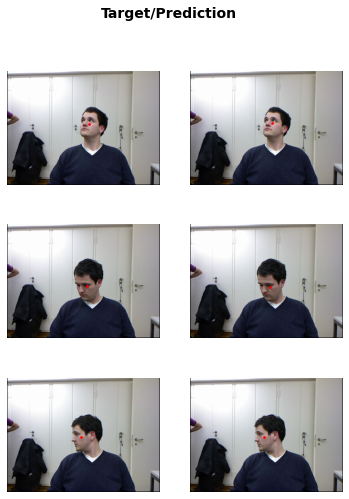

In [62]:
learner.show_results(ds_idx=1, max_n=3, figsize=(6,8))